In [ ]:
#QUESTIONS:
#batch normalization, gotta check what that is

#TODO:
#add regularization!
#break loop for convergence instead of running through all epochs?
#test minmax scaler, not standardcaler in case of outliers
#test log of loan amount column, as the values vary wildly?

In [604]:
# https://github.com/SkalskiP/ILearnDeepLearning.py/blob/master/01_mysteries_of_neural_networks/03_numpy_neural_net/Numpy%20deep%20neural%20network.ipynb
# needs sourced

In [361]:
#importing packages
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import random
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.linear_model import SGDClassifier
import scipy.linalg as scl
import matplotlib.pyplot as plt
import seaborn as sn
sn.set(style="white") #fixes ugly backgrounds

# confusion matrix plotter

In [266]:
def plot_confusion(y_real,y_pred,labs):
    if not labs:
        labs = np.unique(y_real)
    y_real=y_real[:,np.newaxis]
    y_pred=y_pred.reshape(y_real.shape)
    confused = confusion_matrix(y_real,y_pred,sample_weight = None)
    df_cm = pd.DataFrame(confused,columns=labs, index=labs)

    df_cm.index.name = 'Actual'
    df_cm.columns.name ='Predicted'
    plt.figure(figsize=(10,7))
    sn.set(font_scale=1.4)
    ax = sn.heatmap(df_cm, cmap="inferno",annot=True, fmt='g',annot_kws={"size":16})
    first,second=ax.get_ylim()
    ax.set_ylim(first+0.5,0)

# decreasing lr

In [1025]:
def decreasing_lr(t):
#         t0,t1 = 50,500
        t0,t1 = 5,50
        
        return t0/(t+t1)

# define activation/deactivation functions

In [1043]:
def sigmoid(s):
    return 1./(1.+np.exp(-s))
def sigmoid_backprop(da,x):
    sig = sigmoid(x)
    return da*sig*(1-sig)

def ReLU(s):
    return np.maximum(0,s) 
def ReLU_backprop(da,x):
    rel = ReLU(x)
    rel[rel>0]=1
    return da*rel

def tanh(s):
    return np.tanh(s)
def tanh_backprop(da,x):
    tan = tanh(x)
    return da*(1-tan*tan)

def softsign(s):
    return s/(1+np.abs(s))
def softsign_backprop(da,x):
    return da/(1+np.abs(x))**2

def LReLU(s):
    return np.where(s>0,s,s*0.01)
def LReLU_backprop(da,x):
    rel = np.ones_like(x)
    rel[x<0] = 0.01
    return da*rel

def ReLU6(s):
    rel = np.minimum(np.maximum(0,s),6)
    return rel
def ReLU6_backprop(da,x):
    rel = np.zeros_like(ReLU6(x))
    rel[x<=6]=1
    rel[x<=0]=0
    return da*rel

def regression(s):
    return s
def regression_backprop(da,x):
    return da

# create dictionaries for activation/deactivation functions (avoids if tests!)

In [1026]:
activation_functions = {'sigmoid' :sigmoid,
                        'ReLU':ReLU, 
                        'tanh':tanh, 
                        'LReLU':LReLU, 
                        'softsign':softsign,
                        'ReLU6':ReLU6,
                        'regression':regression}

deactivation_functions = {'sigmoid' : sigmoid_backprop, 
                          'ReLU': ReLU_backprop, 
                          'tanh': tanh_backprop, 
                          'LReLU': LReLU_backprop, 
                          'softsign': softsign_backprop,
                          'ReLU6':ReLU6_backprop,
                          'regression':regression_backprop}

# NN class

In [1105]:
class binaryNN:
    def __init__(
            self,
            XTrain,
            yTrain,
            XTest,
            yTest,
            eta,
            nodes_per_layer,
            activation_per_layer,
            classification=True,
            epochs = 10000,
            batch_size=100, #added
            seed=99,
            initialization_method = 'xavier'
        ):
        self.XTrain = XTrain
        self.yTrain = yTrain.T
        self.XTest  = XTest
        self.yTest  = yTest
        self.seed   = seed
        self.classification = classification
        # add final layer, 1 output node, using the sigmoid activation 
        # (so this NN only works for binary classification)

        self.nodes_per_layer = nodes_per_layer.copy()
        self.nodes_per_layer.extend([1])

        self.activation_per_layer = activation_per_layer.copy()
        if self.classification:
            self.activation_per_layer.extend(['sigmoid'])
        else:
            self.activation_per_layer.extend(['regression'])
        

        self.eta = eta
        self.epochs = epochs
        self.batch_size = batch_size
        self.iterations = self.XTrain.shape[0] // self.batch_size
        self.method=initialization_method
        
    def initialize(
            self
        ):
        np.random.seed(self.seed)
        number_of_layers = len(self.activation_per_layer)
        self.nodes_per_layer = np.hstack((self.XTrain.shape[1],self.nodes_per_layer))
        self.parameter_values={}
        for idx in range(len(self.activation_per_layer)):
            layer_idx = idx+1
            layer_input_size = self.nodes_per_layer[idx]
            layer_output_size = self.nodes_per_layer[idx+1]
            np.random.seed(self.seed)
            if self.method == 'standard':
                self.parameter_values['W'+str(layer_idx)] = np.random.randn(
                                    layer_output_size,layer_input_size)*0.1
                self.parameter_values['b'+str(layer_idx)] = np.random.randn(
                                    layer_output_size,1)*0.1   

            elif self.method == 'xavier':
                stdd = np.sqrt(2/(layer_output_size+layer_input_size))
                self.parameter_values['W'+str(layer_idx)] = np.random.normal(
                                    0.0,stdd,size=(layer_output_size,layer_input_size))
                self.parameter_values['b'+str(layer_idx)] = 0
    def forward_propagation(
        self,
        X
        ):
        self.layer_dict = {}
        self.a_current = X.T
        
        for idx in range(len(self.activation_per_layer)):
            layer_idx = idx+1
            self.a_previous = self.a_current
            self.W_current = self.parameter_values["W"+str(layer_idx)]
            self.b_current = self.parameter_values["b"+str(layer_idx)]
            
            self.z_current = self.W_current@self.a_previous+self.b_current
            self.a_current = activation_functions[self.activation_per_layer[idx]](self.z_current)
            
            self.layer_dict["a"+str(idx)] = self.a_previous
            self.layer_dict["z"+str(layer_idx)] = self.z_current
        return self.a_current
    
    def backward_propagation(
        self,
        y
        ):
        self.yBatch = y.T
        self.gradient_values={}
        m = self.yBatch.shape[0]
        if self.classification:
            da_previous = -(np.divide(self.yBatch,self.a_current)-np.divide(1-self.yBatch,1-self.a_current))
        else:
            da_previous = 2.*(self.a_current-self.yBatch)
        for layer_idx_previous in reversed(range(len(self.activation_per_layer))):
            layer_idx_current = layer_idx_previous + 1
            da_current = da_previous

            a_previous = self.layer_dict["a" + str(layer_idx_previous)]
            z_current = self.layer_dict["z" + str(layer_idx_current)]
            W_current = self.parameter_values["W" + str(layer_idx_current)]
            b_current = self.parameter_values["b" + str(layer_idx_current)]

            n = a_previous.shape[1]
            dz_current = deactivation_functions[self.activation_per_layer[layer_idx_current-1]](da_current,z_current)
            dW_current = dz_current@a_previous.T/n
            db_current = np.sum(dz_current,axis=1,keepdims=True)/n
            da_previous = W_current.T@dz_current
            
            self.gradient_values["dW" + str(layer_idx_current)] = dW_current
            self.gradient_values["db" + str(layer_idx_current)] = db_current 
            
    ### COST STUFF
    def cross_entropy(
        self,
        y_pred,
        y_real
        ):
        if self.classification:
            cost = (-1./y_pred.shape[1])*((y_real@(np.log(y_pred).T)+(1-y_real)@(np.log(1-y_pred)).T))
        else:
            cost= mean_squared_error(np.squeeze(y_pred),np.squeeze(y_real))
    
        return cost
    
    def accuracy(
        self,
        y_pred,
        y_real
        ):
        if y_pred.shape[0] != 1:
            y_pred = y_pred.reshape(1,y_pred.shape[0])
        y_real = y_real.reshape(y_pred.shape)
        y_pred_classed = np.copy(y_pred)
        y_pred_classed[y_pred_classed>0.5]=1
        y_pred_classed[y_pred_classed<=0.5]=0
        return (y_pred_classed==y_real).all(axis=0).mean()
    
    ## UPDATE WEIGHTS AND BIASES
    def update(
        self,i,j
        ):
        for layer_idx in range(len(activation_per_layer)):
            layer_idx +=1
#             eta = decreasing_lr(i*self.iterations+j)
            eta=decreasing_lr(i)
            self.parameter_values["W" + str(layer_idx)] -= eta * self.gradient_values["dW" + str(layer_idx)]        
            self.parameter_values["b" + str(layer_idx)] -= eta * self.gradient_values["db" + str(layer_idx)]
#             self.parameter_values["W" + str(layer_idx)] -= self.eta * self.gradient_values["dW" + str(layer_idx)]        
#             self.parameter_values["b" + str(layer_idx)] -= self.eta * self.gradient_values["db" + str(layer_idx)]
            
    def train(
        self
        ):
        self.initialize()
        self.cost_history = []
        self.accuracy_history = []
        self.cost_history_test = []
        self.accuracy_history_test=[]
        data_indices = np.arange(self.XTrain.shape[0])
        for i in range(self.epochs):
            if i%1000==0:
                print("Calculating epoch ",i)
            for j in range(self.iterations):
                chosen_datapoints = np.random.choice(
                    data_indices,size=self.batch_size,replace=False)
                self.XData = self.XTrain[chosen_datapoints]
                self.yData = self.yTrain[chosen_datapoints]
                self.forward_propagation(self.XData)
                self.backward_propagation(self.yData)
                self.update(i,j)
              
#             self.forward_propagation(self.XTrain)
#             self.backward_propagation(self.yTrain)
#             self.update(i,1)
            
            
            trainer = self.forward_propagation(self.XTrain)
            cost = self.cross_entropy(trainer,self.yTrain)
            self.cost_history.append(cost)
            accuracy = self.accuracy(trainer, self.yTrain)
            self.accuracy_history.append(accuracy)
            
            tester = self.forward_propagation(self.XTest)
            cost_test = self.cross_entropy(tester,self.yTest)
            self.cost_history_test.append(cost_test)
            accuracy_test = self.accuracy(tester, self.yTest)
            self.accuracy_history_test.append(accuracy_test)

            #test
            if self.classification:
                self.y_pred_ = self.forward_propagation(self.XTrain)
                self.y_pred_[self.y_pred_>=0.5]=1
                self.y_pred_[self.y_pred_<0.5]=0

# nn architecture

In [1028]:
nodes_per_layer = [100,50,70,80]
activation_per_layer = ['sigmoid','ReLU','ReLU','ReLU']

# nodes_per_layer = [100,50]
# activation_per_layer = ['ReLU','ReLU'] #good on moons

# nodes_per_layer = [100,100]
# activation_per_layer = ['ReLU','ReLU']

# testing on franke

In [1029]:
"""
This is an "uglified" version of the FrankeFunction, to minimize use of costly functions like 
divisions and powers.
It takes as input parameters a meshgrid of coordinates in the x and y direction.
"""
def FrankeFunction(x,y): #still got one division in here
    term1 = 0.75*np.exp(-(0.25*(9*x-2)*(9*x-2)) - 0.25*((9*y-2)*(9*y-2)))
    term2 = 0.75*np.exp(-((9*x+1)*(9*x+1))/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)*(9*x-7)*0.25 - 0.25*((9*y-3)*(9*y-3)))
    term4 = -0.2*np.exp(-(9*x-4)*(9*x-4) - (9*y-7)*(9*y-7))
    return term1 + term2 + term3 + term4

In [1030]:
def Model(x,y,P): 
    m = len(x)*len(y) # number of equations
    t = sum(range(P+2)) # number of terms in polynomial
    X = np.zeros((m,t)) # Model matrix
    a = np.matrix.flatten(x)
    b = np.matrix.flatten(y)
    c = 0 #counter
    for i in range(P+1):
        for j in range(P+1-i):
            X[:,c] = a**j*b**i
            c +=1
    return X

In [1130]:
N = 100 #number of points along x and y axes
n=10

# sort this for meshgrid
x = np.sort(np.random.uniform(0,1,N))
y = np.sort(np.random.uniform(0,1,N))
x, y = np.meshgrid(x,y,sparse=False)

#create datapoints/results
z = FrankeFunction(x, y)

# Create noise
noise_weight = 0.1 #might wanna make a function for this to loop over weights?
Noise = noise_weight*np.random.randn(N,N)

#add noise
z_noise = z+Noise

#flatten for use in functions
z_n = np.matrix.flatten(z_noise)
X_matr = np.c_[np.matrix.flatten(x),np.matrix.flatten(y),z_n]
np.random.shuffle(X_matr)
Xshuf,yshuf = X_matr[:,:2],X_matr[:,2]
# X_matr = Model(x,y,5)
print(len(z_n))

10000


In [1132]:
x_train_franke,x_test_franke,y_train_franke,y_test_franke = train_test_split(Xshuf,yshuf,test_size=0.1,random_state = 2)

In [1133]:
#nn architecture
# activation_per_layer = ['ReLU','ReLU','ReLU','ReLU','ReLU6', 'tanh','LReLU','ReLU']
# nodes_per_layer = [1000,900,800,500,200,150,100,50]

# nodes_per_layer= [200, 100,100,50]
# activation_per_layer=[ 'ReLU6','sigmoid','ReLU','LReLU']# 100,100. relu relu gives 0.785 test r2 for 5th order model.
nodes_per_layer = [1000,500]
activation_per_layer = ['ReLU6','LReLU']

In [1134]:
frankie = binaryNN(x_train_franke,y_train_franke,x_test_franke,y_test_franke,0.01,nodes_per_layer,activation_per_layer,classification=False,epochs=1000)
frankie.train()

Calculating epoch  0


mse 0.011675478974711464
r2 0.8784503108477556
mse 0.011224246943213355
r2 0.8807299581456507


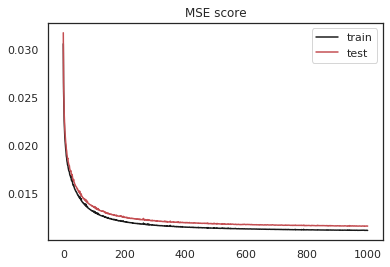

In [1135]:
Y_test_franke = np.squeeze(frankie.forward_propagation(x_test_franke))
Y_train_franke = np.squeeze(frankie.forward_propagation(x_train_franke))
from sklearn.metrics import mean_squared_error,r2_score
print("mse",mean_squared_error(Y_test_franke,y_test_franke))
print("r2",r2_score(y_test_franke,Y_test_franke))
print("mse",mean_squared_error(Y_train_franke,y_train_franke))
print("r2",r2_score(y_train_franke,Y_train_franke))

plt.title('MSE score')
plt.plot(frankie.cost_history[:],'k',label='train')
plt.plot(frankie.cost_history_test[:],'r',label='test')
plt.legend()
plt.show()

In [1128]:
x = sorted(np.random.rand(100,1))
y = sorted(np.random.rand(100,1))
x,y = np.meshgrid(x,y)

# X=np.c_[x,y]
# z = 5*x*x+4*y+0.1*np.random.randn(100,1)
def funfun(x,y):
    return 5*x*x+4*y+0.1*np.random.randn(100,1)
z= funfun(x,y)
# z=z.flatten()
# print(np.shape(z))
X=np.c_[x.flatten(),y.flatten(),z.flatten()]
np.random.shuffle(X)
Xs,zs=X[:,:2],X[:,2]
print(np.shape(Xs),np.shape(zs))
# print(np.shape(X))
# plt.figure()
# plt.plot(sorted(x),sorted(y))
# plt.show()
# x = np.array(sorted(x))
# y = np.array(sorted(y))
nodes_per_layer = [5,2,1]
activation_per_layer = ['ReLU','ReLU','ReLU']
xtr,xte,ytr,yte = train_test_split(Xs,zs,test_size=0.1,random_state=2)
print(np.shape(xtr),np.shape(xte),np.shape(ytr),np.shape(yte))
one_dim = binaryNN(xtr,ytr,xte,yte,0.01,nodes_per_layer,activation_per_layer,classification=False,epochs=1000)
one_dim.train()

(10000, 2) (10000,)
(9000, 2) (1000, 2) (9000,) (1000,)
Calculating epoch  0


mse 16.5858168897506
r2 -3.7787316045546078
mse 16.224719006659114
r2 -3.6662838926617276


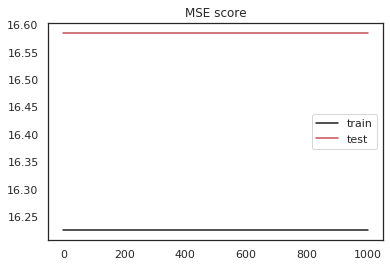

In [1129]:
# plt.figure()
# plt.scatter(xte,yte)
# plt.scatter(xte,one_dim.forward_propagation(xte))
# plt.show()

Y_test_franke = np.squeeze(one_dim.forward_propagation(xte))
Y_train_franke = np.squeeze(one_dim.forward_propagation(xtr))
from sklearn.metrics import mean_squared_error,r2_score
print("mse",mean_squared_error(Y_test_franke,yte))
print("r2",r2_score(yte,Y_test_franke))
print("mse",mean_squared_error(Y_train_franke,ytr))
print("r2",r2_score(ytr,Y_train_franke))

plt.title('MSE score')
plt.plot(one_dim.cost_history[:],'k',label='train')
plt.plot(one_dim.cost_history_test[:],'r',label='test')
plt.legend()
plt.show()

In [686]:
acts = ['sigmoid',
                        'ReLU', 
                        'tanh', 
                        'LReLU', 
                        'softsign',
                        'ReLU6']

test_cases=10
for i in range(test_cases):
    np.random.seed(i)
    n_layers = np.random.randint(2,5)
    nodes_per_layer=[]
    activation_per_layer=[]
    for j in range(n_layers):
        nodes_per_layer.append(np.random.randint(10,100))
        a = np.random.choice(acts)
        activation_per_layer.append(a)
    print(activation_per_layer)
    nodes_per_layer = sorted(nodes_per_layer,reverse=True)
    print(nodes_per_layer)
    
    frankie = binaryNN(x_train_franke,y_train_franke,x_test_franke,y_test_franke,0.01,nodes_per_layer,activation_per_layer,epochs=10000)
    frankie.train() 
    
    Y_test_franke = np.squeeze(frankie.forward_propagation(x_test_franke))

    print("mse",mean_squared_error(Y_test_franke,y_test_franke))
    print("r2",r2_score(y_test_franke,Y_test_franke))


['ReLU6', 'LReLU']
[74, 57]
Calculating epoch  0
Calculating epoch  1000
Calculating epoch  2000
Calculating epoch  3000
Calculating epoch  4000
Calculating epoch  5000
Calculating epoch  6000
Calculating epoch  7000
Calculating epoch  8000
Calculating epoch  9000
mse 0.09647844285525445
r2 0.005513727310486716
['sigmoid', 'LReLU', 'sigmoid']
[22, 19, 15]
Calculating epoch  0
Calculating epoch  1000
Calculating epoch  2000
Calculating epoch  3000
Calculating epoch  4000
Calculating epoch  5000
Calculating epoch  6000
Calculating epoch  7000
Calculating epoch  8000
Calculating epoch  9000
mse 0.11566368895725374
r2 -0.19224510172900144
['ReLU6', 'LReLU']
[82, 25]
Calculating epoch  0
Calculating epoch  1000
Calculating epoch  2000
Calculating epoch  3000
Calculating epoch  4000
Calculating epoch  5000
Calculating epoch  6000
Calculating epoch  7000
Calculating epoch  8000
Calculating epoch  9000
mse 0.09132912588239747
r2 0.0585921652669974
['ReLU', 'sigmoid', 'sigmoid', 'ReLU6']
[82, 3

KeyboardInterrupt: 

# testing on skl moon data

In [653]:
# number of samples in the data set
N_SAMPLES = 1000
# ratio between training and test sets
TEST_SIZE = 0.1

from sklearn.datasets import make_moons
X, y = make_moons(n_samples = N_SAMPLES, noise=0.2, random_state=100)
X_train_moons, X_test_moons, y_train_moons, y_test_moons = train_test_split(X, y, test_size=TEST_SIZE, random_state=42)

In [657]:
Moons = binaryNN(X_train_moons,y_train_moons,X_test_moons, y_test_moons,0.01,nodes_per_layer,activation_per_layer,epochs=10000)
Moons.train()

Calculating epoch  0
Calculating epoch  1000
Calculating epoch  2000
Calculating epoch  3000
Calculating epoch  4000
Calculating epoch  5000
Calculating epoch  6000
Calculating epoch  7000


KeyboardInterrupt: 

Test set accuracy: 0.96 
Zero set accuracy: 0.54 


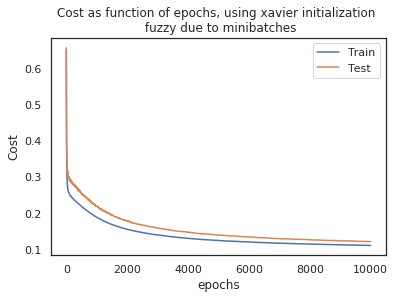

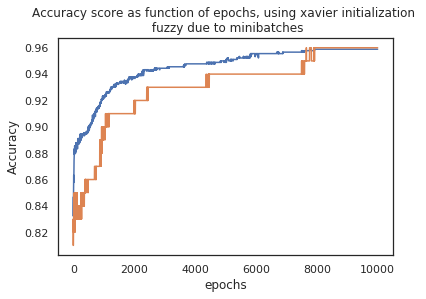

In [633]:
Y_test_hat_moons = Moons.forward_propagation(X_test_moons)
acc_test_moons = Moons.accuracy(Y_test_hat_moons, y_test_moons)
print("Test set accuracy: {:.2f} ".format(acc_test_moons))
zerot_moons = np.zeros(y_test_moons.shape[0])
acc_test_moons2 = Moons.accuracy(y_test_moons, zerot_moons)
print("Zero set accuracy: {:.2f} ".format(acc_test_moons2))

plt.figure()
plt.plot(Moons.cost_history,label='Train')
plt.plot(Moons.cost_history_test,label='Test')
plt.title("Cost as function of epochs, using xavier initialization \n fuzzy due to minibatches")
plt.xlabel("epochs")
plt.ylabel("Cost")
plt.legend()
plt.show()


plt.figure()
plt.plot(Moons.accuracy_history,label='Train')
plt.plot(Moons.accuracy_history_test,label='Test')
plt.title("Accuracy score as function of epochs, using xavier initialization \n fuzzy due to minibatches")
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.show()

In [634]:
Moons_standard = binaryNN(X_train_moons,y_train_moons,X_test_moons,y_test_moons,0.01,nodes_per_layer,activation_per_layer,epochs=10000,initialization_method='standard')
Moons_standard.train()

Calculating epoch  0
Calculating epoch  1000
Calculating epoch  2000
Calculating epoch  3000
Calculating epoch  4000


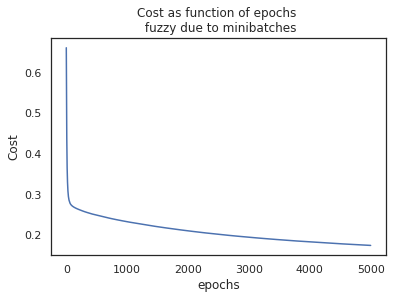

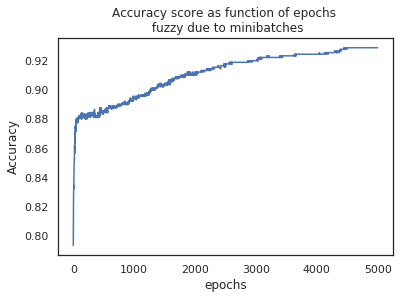

In [637]:
plt.figure()
plt.plot(Moons_standard.cost_history,label='train')
plt.plot(Moons_standard.cost_history_test,label='test')
plt.title("Cost as function of epochs \n fuzzy due to minibatches")
plt.xlabel("epochs")
plt.ylabel("Cost")
plt.legend()
plt.show()


plt.figure()
plt.plot(Moons_standard.accuracy_history,label='train')
plt.plot(Moons_standard.accuracy_history_test,label='test')
plt.title("Accuracy score as function of epochs \n fuzzy due to minibatches")
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

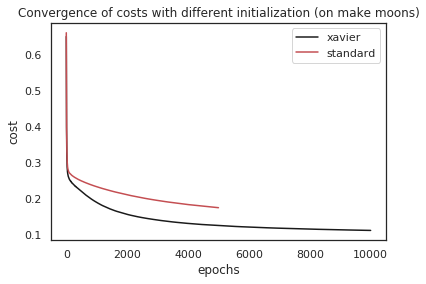

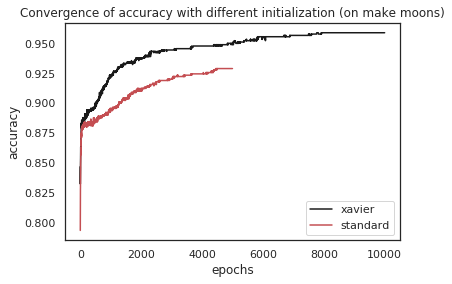

In [636]:

plt.figure()
plt.plot(Moons.cost_history,'k',label='xavier')
plt.plot(Moons_standard.cost_history,'r',label='standard')
plt.xlabel("epochs")
plt.ylabel("cost")
plt.title("Convergence of costs with different initialization (on make moons)")
plt.legend()
plt.show()

plt.figure()
plt.plot(Moons.accuracy_history,'k',label='xavier')
plt.plot(Moons_standard.accuracy_history,'r',label='standard')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("Convergence of accuracy with different initialization (on make moons)")
plt.legend()
plt.show()

# confusion matrix

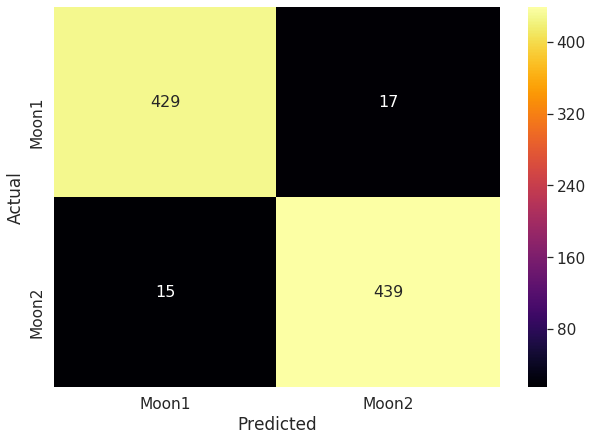

In [271]:
yyy = y_train_moons
ppp = Moons.y_pred_
lab=["Moon1","Moon2"]
plot_confusion(yyy,ppp,lab)

# testing on credit card data

In [762]:
def ReadData():
    #importing data set(s)
    filename = 'default of credit card clients.xls'
    nanDict = {} #this does nothing with this data set
    #read file
    df = pd.read_excel(filename,header=1,skiprows=0,index_col=0,na_values=nanDict) 
    #rename last column
    df.rename(index=str, columns={"default payment next month": "defaultPaymentNextMonth"}, inplace=True)
    #Replace nonsensical values in PAY_i columns with 0
    for i in [0,2,3,4,5,6]:
        col = 'PAY_{}'.format(i)
        df[col].replace(to_replace=-2, value = 0, inplace=True)
    #shuffle dataset by row
    df.sample(frac=1)
    
    # Define features and targets 
    X = df.loc[:, df.columns != 'defaultPaymentNextMonth'].values
    y = df.loc[:, df.columns == 'defaultPaymentNextMonth'].values
    
    # Categorical variables to one-hots, setting nonsensical values to 0
    onehotencoder1 = OneHotEncoder(categories='auto')
    onehotencoder2 = OneHotEncoder(categories='auto',drop='first')

    # sets number of elements in onehot vectors automatically from data.
    Xt= ColumnTransformer(
        [("one", onehotencoder1, [1]),("two", onehotencoder2, [2,3]),],
        remainder="passthrough"
    ).fit_transform(X)

    # Train-test split
    trainingShare = 0.5
    seed  = 1
    XTrain, XTest, yTrain, yTest=train_test_split(Xt, y, train_size=trainingShare, \
                                                  test_size = 1-trainingShare,
                                                 random_state=seed, stratify = y)
    
    #scale data, except one-hotted
    sc = StandardScaler()
    XTrain_fitting = XTrain[:,11:]
    XTest_fitting = XTest[:,11:]
    #removes mean, scales by std
    XTrain_scaler = sc.fit_transform(XTrain_fitting)
    XTest_scaler = sc.transform(XTest_fitting)
    #puts together the complete model matrix again
    XTrain_scaled=np.c_[XTrain[:,:11],XTrain_scaler]
    XTest_scaled = np.c_[XTest[:,:11],XTest_scaler]


    
    
    return XTrain_scaled,XTest_scaled,yTrain,yTest

In [763]:
#reading data
XTrain_cc,XTest_cc,yTrain_cc,yTest_cc = ReadData()
print(np.shape(XTrain_cc),np.shape(np.squeeze(yTrain_cc)))

(15000, 31) (15000,)


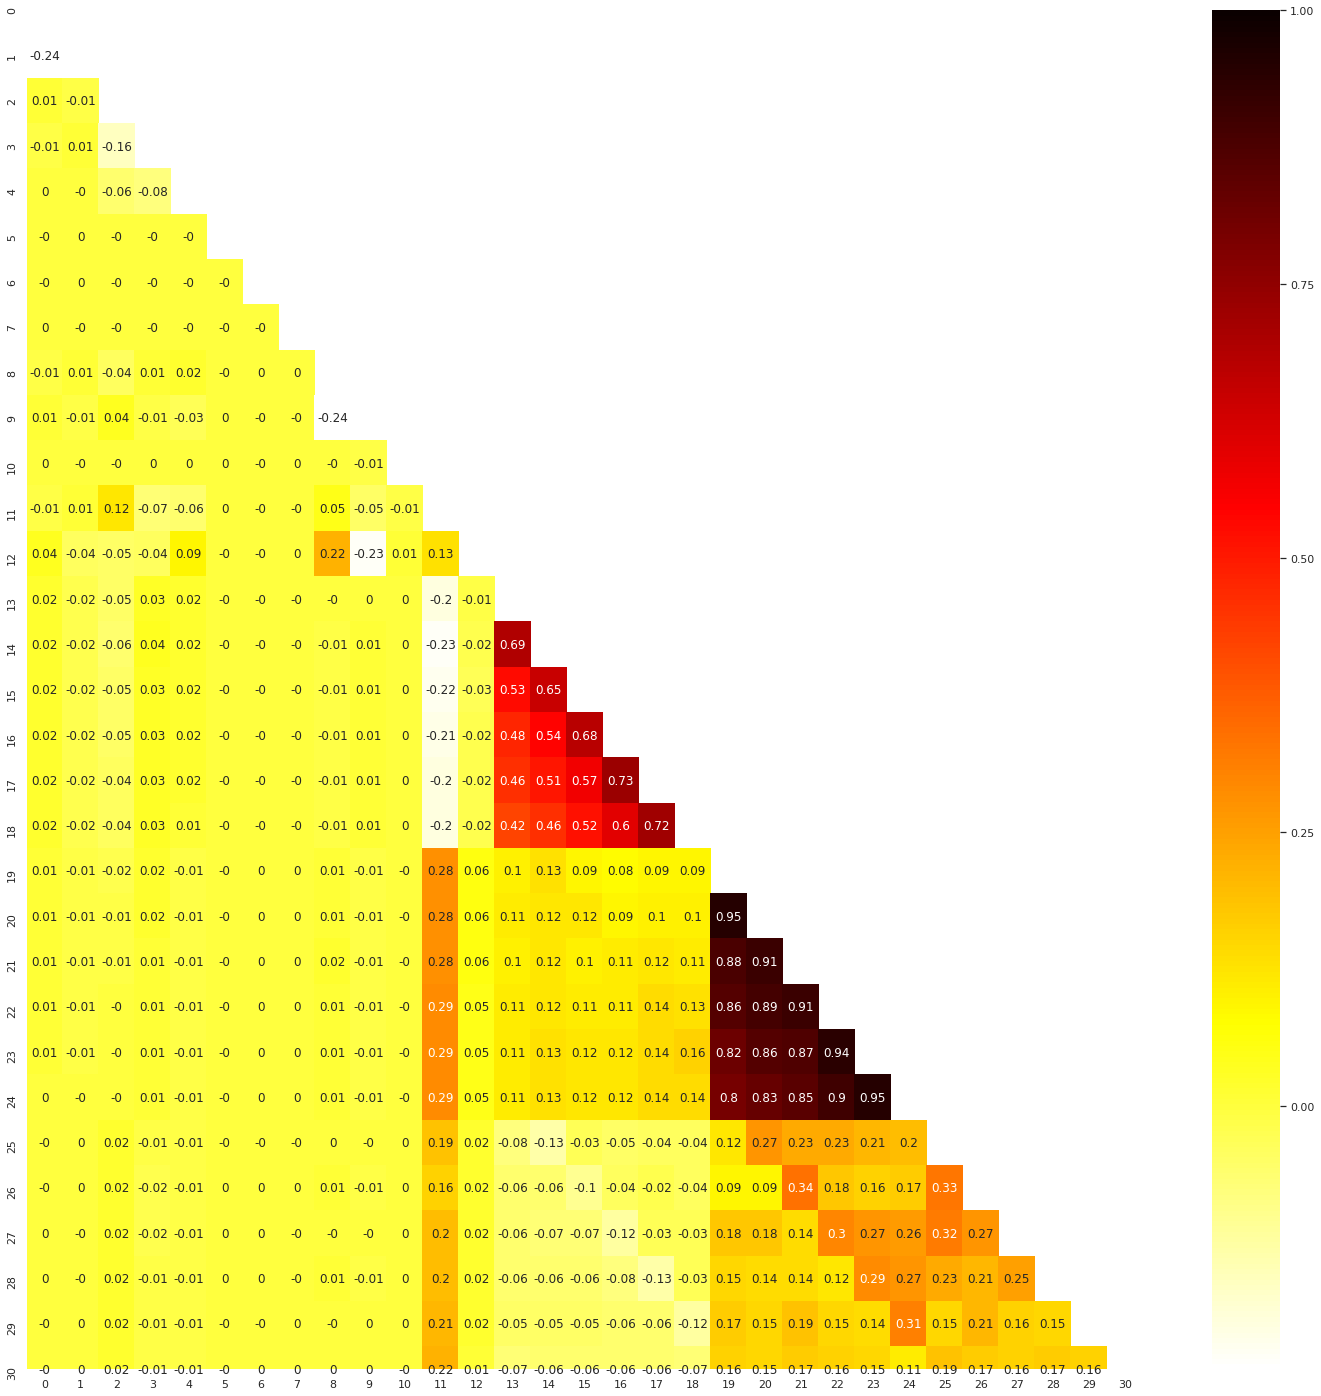

In [764]:
creditpd = pd.DataFrame(XTrain_cc)
covmat = creditpd.cov().round(2)

# Generate a mask for the upper triangle
mask = np.zeros_like(covmat, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(25,25))
sn.heatmap(data=covmat,mask=mask,cmap='hot_r', annot=True)
plt.show()

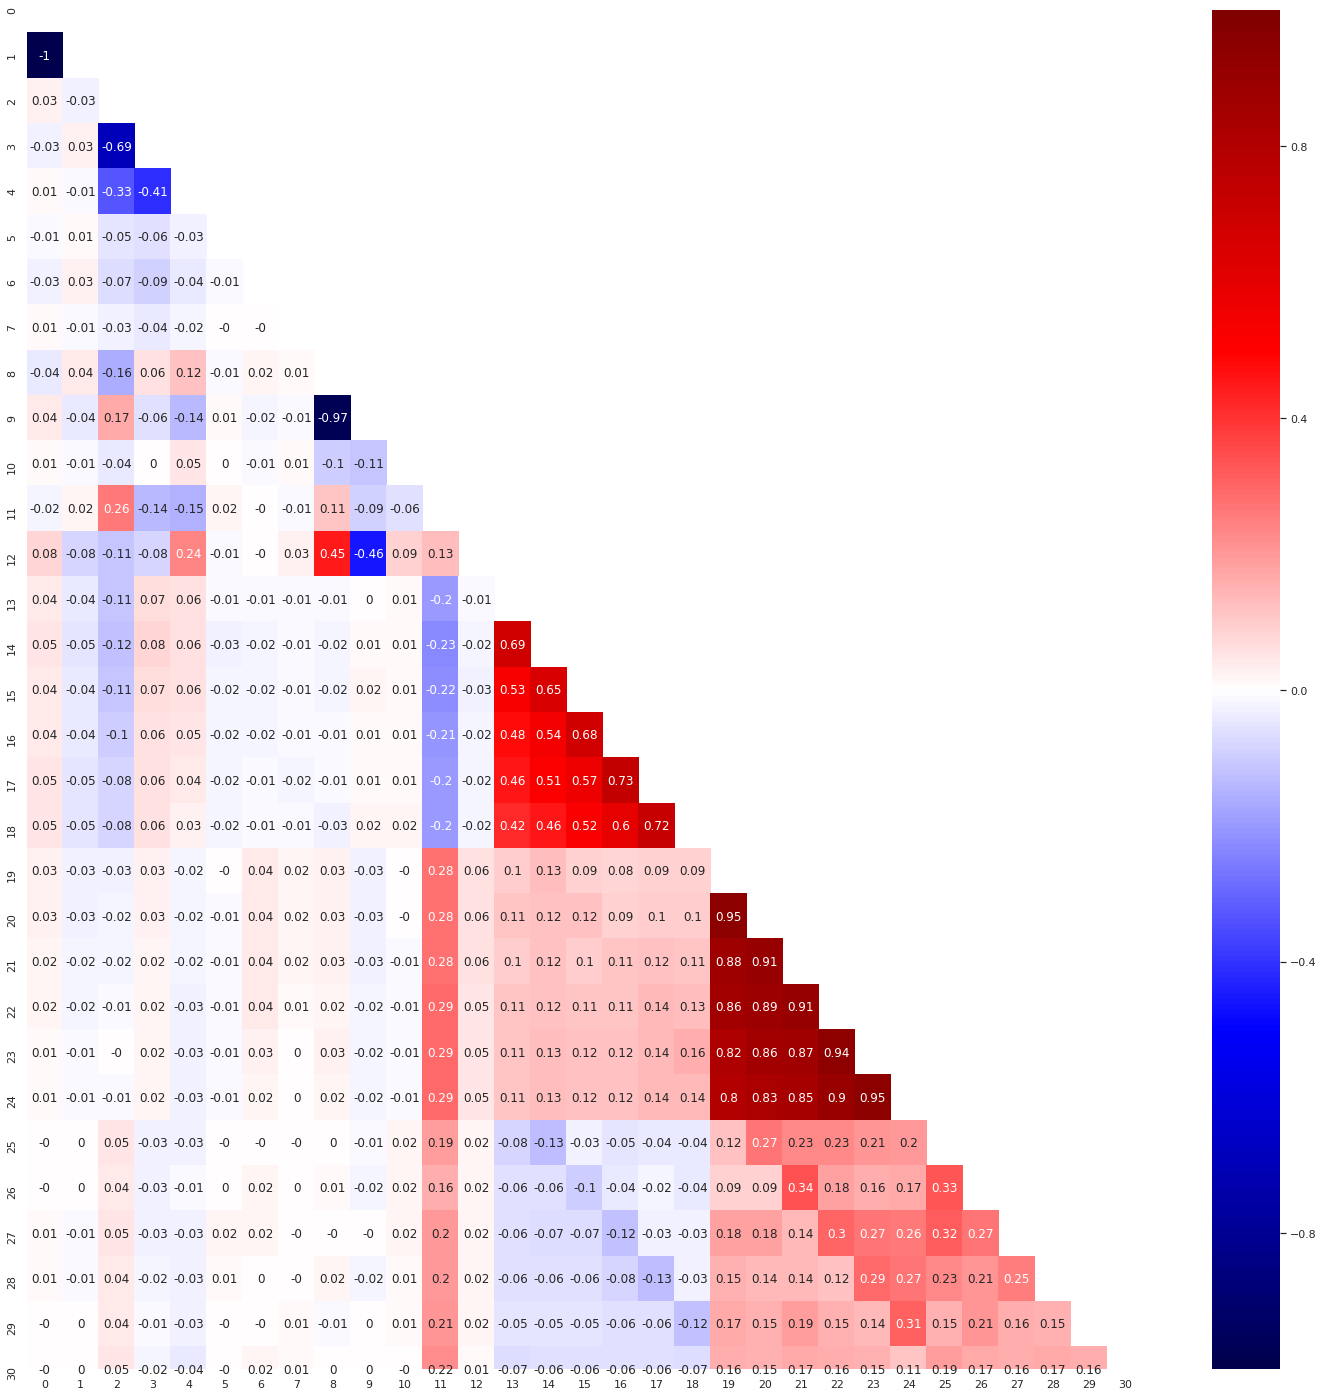

In [765]:
creditpd = pd.DataFrame(XTrain_cc)
corrmat = creditpd.corr().round(2)

# Generate a mask for the upper triangle
mask = np.zeros_like(corrmat, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(25,25))
sn.heatmap(cmap='seismic',data=corrmat,mask=mask, annot=True)
plt.show()

In [ ]:
nodes_per_layer = [100,100]
activation_per_layer = ['ReLU','ReLU']

In [769]:
# train network
CreditCard = binaryNN(XTrain_cc,np.squeeze(yTrain_cc),XTest_cc,np.squeeze(yTrain_cc),0.01,nodes_per_layer,activation_per_layer)
CreditCard.train()

Calculating epoch  0
Calculating epoch  1000
Calculating epoch  2000
Calculating epoch  3000
Calculating epoch  4000
Calculating epoch  5000
Calculating epoch  6000


KeyboardInterrupt: 

In [638]:
#find accuracy scores
Y_test_hat_cc = CreditCard.forward_propagation(XTest_cc)
# # Accuracy achieved on the test set
acc_test_cc = CreditCard.accuracy(Y_test_hat_cc, yTest_cc)
print("Test set accuracy: {:.2f} ".format(acc_test_cc))
zerot = np.zeros(yTest_cc.shape[0])
acc_test_cc2 = CreditCard.accuracy(np.transpose(yTest_cc.reshape((yTest_cc.shape[0], 1))), np.transpose(zerot.reshape((zerot.shape[0], 1))))

acc_test_cc2 = CreditCard.accuracy(yTest_cc,zerot)
print("Zero set accuracy: {:.2f} ".format(acc_test_cc2))

Test set accuracy: 0.77 
Zero set accuracy: 0.78 


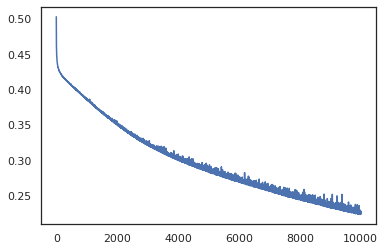

In [639]:
plt.plot(CreditCard.cost_history)

In [ ]:
plt.plot((CreditCard.accuracy_history))

In [285]:
print(np.shape(XTrain_cc),np.shape(yTrain_cc))
XTrain_cc_small = XTrain_cc[:1000]
XTest_cc_small = XTest_cc[:1000]
yTrain_cc_small = yTrain_cc[:1000]
yTest_cc_small = yTest_cc[:1000]
print(np.shape(XTrain_cc_small),np.shape(yTrain_cc_small))


(15000, 31) (15000, 1)
(1000, 31) (1000, 1)


In [ ]:
#reduce dims

from sklearn.decomposition import PCA
import time
n_comp = XTrain_cc_small.shape[1]
pca = PCA(n_components=XTrain_cc_small.shape[1])
X2D = pca.fit_transform(XTrain_cc_small)
X2Dt = pca.transform(XTest_cc_small)
print(np.shape(X2D))
nodes_per_layer = [100,50]
activation_per_layer = ['ReLU','ReLU']

fragle = binaryNN(X2D,np.squeeze(yTrain_cc_small),X2Dt,np.squeeze(yTest_cc_small),0.01,nodes_per_layer,activation_per_layer,epochs=5000)
start = time.time()

fragle.train()
end = time.time()
print("Training time with {} features: {}s".format(n_comp,end-start))
Y_test_hat_cc_small = fragle.forward_propagation(X2Dt)
# # Accuracy achieved on the test set
acc_test_cc_small = CreditCard.accuracy(Y_test_hat_cc_small, yTest_cc_small)
print("Test set accuracy: {:.2f} ".format(acc_test_cc_small))
y_pred = np.squeeze(Y_test_hat_cc_small)
y_real = np.squeeze(yTest_cc_small)


y_pred_classed = np.copy(y_pred)
y_pred_classed[y_pred_classed>0.5]=1
y_pred_classed[y_pred_classed<=0.5]=0
formula1 = f1_score(y_pred_classed,y_real)
print("f1 score: {}".format(formula1))
print("AUROC score: {}".format(sklearn.metrics.roc_auc_score(y_real,y_pred)))

In [ ]:
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score
n_comp = 18
pca = PCA(n_components=n_comp)
X2D = pca.fit_transform(XTrain_cc_small)
X2Dt = pca.transform(XTest_cc_small)
print(np.shape(X2D))
nodes_per_layer = [100,50]
activation_per_layer = ['tanh','ReLU']
fragle = binaryNN(X2D,np.squeeze(yTrain_cc_small),X2Dt,np.squeeze(yTest_cc_small),0.01,nodes_per_layer,activation_per_layer,epochs=5000)
start = time.time()
fragle.train()
end = time.time()
print("Training time with {} features: {}s".format(n_comp,end-start))

Y_test_hat_cc_small = fragle.forward_propagation(X2Dt)
# # Accuracy achieved on the test set
acc_test_cc_small = CreditCard.accuracy(Y_test_hat_cc_small, yTest_cc_small)
print("Test set accuracy: {:.2f} ".format(acc_test_cc_small))
# print(np.shape(Y_test_hat_cc_small),np.shape(yTest_cc_small))
y_pred = np.squeeze(Y_test_hat_cc_small)
y_real = np.squeeze(yTest_cc_small)


y_pred_classed = np.copy(y_pred)
y_pred_classed[y_pred_classed>0.5]=1
y_pred_classed[y_pred_classed<=0.5]=0
formula1 = f1_score(y_pred_classed,y_real)
print("f1 score: {}".format(formula1))
print("AUROC score: {}".format(sklearn.metrics.roc_auc_score(y_real,y_pred)))


In [419]:
#50/50 sampling
indy_0 =[]
indy_1=[]
for i in range(yTrain_cc.shape[0]):
    if yTrain_cc[i]==0:
        indy_0.append(i)
    if yTrain_cc[i]==1:
        indy_1.append(i)

x_halved_0 = XTrain_cc[indy_0,:]
x_halved_1 = XTrain_cc[indy_1,:]

idx = np.random.choice(x_halved_0.shape[0],size=3300,replace=False)
x_0 = x_halved_0[idx,:]
idy = np.random.choice(x_halved_1.shape[0],size=3300,replace=False)
x_1 = x_halved_1[idy,:]
x_runner = np.vstack((x_0,x_1))
y_runner = np.zeros(6600)
y_runner[3300:]=1
y_runner = y_runner[:,np.newaxis]

3318


In [420]:
#reduce dims

from sklearn.decomposition import PCA
import time
n_comp = x_runner.shape[1]
pca = PCA(n_components=x_runner.shape[1])
X2D = pca.fit_transform(x_runner)
X2Dt = pca.transform(XTest_cc_small)
print(np.shape(X2D))
nodes_per_layer = [100,50]
activation_per_layer = ['ReLU','ReLU']

fragle = binaryNN(X2D,np.squeeze(y_runner),X2Dt,np.squeeze(yTest_cc_small),0.01,nodes_per_layer,activation_per_layer,epochs=5000)
start = time.time()

fragle.train()
end = time.time()
print("Training time with {} features: {}s".format(n_comp,end-start))
Y_test_hat_cc_small = fragle.forward_propagation(X2Dt)
# # Accuracy achieved on the test set
acc_test_cc_small = CreditCard.accuracy(Y_test_hat_cc_small, yTest_cc_small)
print("Test set accuracy: {:.2f} ".format(acc_test_cc_small))
y_pred = np.squeeze(Y_test_hat_cc_small)
y_real = np.squeeze(yTest_cc_small)


y_pred_classed = np.copy(y_pred)
y_pred_classed[y_pred_classed>0.5]=1
y_pred_classed[y_pred_classed<=0.5]=0
formula1 = f1_score(y_pred_classed,y_real)
print("f1 score: {}".format(formula1))
print("AUROC score: {}".format(sklearn.metrics.roc_auc_score(y_real,y_pred)))

(6600, 31)
Calculating epoch  0
Calculating epoch  1000
Calculating epoch  2000
Calculating epoch  3000
Calculating epoch  4000
Training time with 31 features: 423.6923749446869s
Test set accuracy: 0.67 
f1 score: 0.4602649006622516


NameError: name 'sklearn' is not defined

In [ ]:
#reduce dims

from sklearn.decomposition import PCA
import time
n_comp = x_runner.shape[1]
pca = PCA(n_components=18)
X2D = pca.fit_transform(x_runner)
X2Dt = pca.transform(XTest_cc_small)
print(np.shape(X2D))
nodes_per_layer = [100,50]
activation_per_layer = ['ReLU','ReLU']

fragle = binaryNN(X2D,np.squeeze(y_runner),X2Dt,np.squeeze(yTest_cc_small),0.01,nodes_per_layer,activation_per_layer,epochs=5000)
start = time.time()

fragle.train()
end = time.time()
print("Training time with {} features: {}s".format(n_comp,end-start))
Y_test_hat_cc_small = fragle.forward_propagation(X2Dt)
# # Accuracy achieved on the test set
acc_test_cc_small = CreditCard.accuracy(Y_test_hat_cc_small, yTest_cc_small)
print("Test set accuracy: {:.2f} ".format(acc_test_cc_small))
y_pred = np.squeeze(Y_test_hat_cc_small)
y_real = np.squeeze(yTest_cc_small)


y_pred_classed = np.copy(y_pred)
y_pred_classed[y_pred_classed>0.5]=1
y_pred_classed[y_pred_classed<=0.5]=0
formula1 = f1_score(y_pred_classed,y_real)
print("f1 score: {}".format(formula1))
print("AUROC score: {}".format(sklearn.metrics.roc_auc_score(y_real,y_pred)))

In [ ]:
acts = ['sigmoid',
                        'ReLU', 
                        'tanh', 
                        'LReLU', 
                        'softsign',
                        'ReLU6']
# acts = ['sigmoid','ReLU']


# test_0_ind = yTest_cc[yTest_cc==0]
# test_1_ind = yTest_cc[yTest_cc==1]
# # print(len(test_1_ind))
# # print(len(test_0_ind))
# x_halved_0 = XTest_cc[test_0_ind,:]
# x_halved_1 = XTest_cc[test_1_ind,:]

# x_0 = x_halved_0[:500]
# x_1 = x_halved_1[:500]
# x_runner = np.vstack((x_0,x_1))
# # print(np.shape(x_runner))
# y_runner = np.zeros(1000)
# y_runner[500:]=1

test_cases=10
for i in range(test_cases):
    np.random.seed(i)
    n_layers = np.random.randint(2,10)
    nodes_per_layer=[]
    activation_per_layer=[]
    for j in range(n_layers):
        nodes_per_layer.append(np.random.randint(10,1000))
        a = np.random.choice(acts)
        activation_per_layer.append(a)
    print(activation_per_layer)
    nodes_per_layer = sorted(nodes_per_layer,reverse=True)
    print(nodes_per_layer)

    CreditCard_small = binaryNN(XTrain_cc_small,np.squeeze(yTrain_cc_small),0.01,nodes_per_layer,activation_per_layer,epochs=5000)
    CreditCard_small.train()    
    
#     CreditCard_small = binaryNN(x_runner,np.squeeze(y_runner),XTest_cc,np.squeeze(yTest_cc),0.01,nodes_per_layer,activation_per_layer,epochs=5000)
#     CreditCard_small.train()
    #find accuracy scores
    Y_test_hat_cc_small = CreditCard_small.forward_propagation(XTest_cc_small)
    # # Accuracy achieved on the test set
    acc_test_cc_small = CreditCard_small.accuracy(Y_test_hat_cc_small, yTest_cc_small)
    print("Test set accuracy: {:.2f} ".format(acc_test_cc_small))
    zerot = np.zeros(yTest_cc_small.shape[0])
    acc_test_cc2_small = CreditCard_small.accuracy(np.transpose(yTest_cc_small.reshape((yTest_cc_small.shape[0], 1))), np.transpose(zerot.reshape((zerot.shape[0], 1))))

    acc_test_cc2_small = CreditCard_small.accuracy(yTest_cc_small,zerot)
    print("Zero set accuracy: {:.2f} ".format(acc_test_cc2_small))

In [ ]:
# maybe relu/relu6 should be weighted higher? 
# do it in a hacky way by adding more of them into the acts array?